In [65]:
# Let's bring in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Importing Linear Regression
from sklearn.linear_model import LinearRegression

# Now going to do some time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Introduction

Welcome to my notebook! In this project, we will explore New York City property sales data to identify neighborhoods experiencing similar trends. This analysis can provide valuable insights for investors, city planners, and residents alike, as it will shed light on the dynamics of different neighborhoods and help uncover underlying patterns in the market.

## Project Objective

Our main objective is to:

* Extract trends from each neighborhood using Fourier transform
* Apply clustering techniques to group neighborhoods with similar trends
Dataset

We will be working with a dataset containing 442,381 records of property sales in New York City from 2014 to 2018. This comprehensive dataset provides us with a solid foundation for analyzing trends and patterns across the city's neighborhoods.

## Methodology

1. Data Preparation: First, we will clean and preprocess the data, ensuring its quality and addressing any inconsistencies or missing values.

2. Fourier Transform: Next, we will apply the Fourier transform to extract trends from the time series data for each neighborhood. This will help us identify dominant frequencies and patterns in property sales.

3. Clustering: Finally, we will employ clustering techniques, such as K-means or hierarchical clustering, to group neighborhoods with similar trends together. This will allow us to better understand the relationships between neighborhoods and their property sales patterns.

Let's dive into the analysis and start uncovering the hidden patterns in New York City's property sales!



`Please note, I will not be foucsing on EDA in the notebook, which I have done previously. I will be focusing on using Fourier Transform and Clustering to extract trends for this project.`

### Step 1: Load Datasets

We will begin by loading the datasets for years 2014 to 2018. We will do a bit of standardizing the name columns, then we will then combine them into a single dataframe and inspect the first few rows to get a sense of the data.

In [50]:
df_18 = pd.read_csv('2018_NYC_Property_Sales__10172019.csv')
df_17 = pd.read_csv('2017_NYC_Property_Sales__10172019.csv')
df_16 = pd.read_csv('2016_NYC_Property_Sales__10172019.csv')
df_15 = pd.read_csv('2015_NYC_Property_Sales__10172019.csv')
df_14 = pd.read_csv('2014_NYC_Property_Sales__10172019.csv')

# Renaming column "TAX CLASS AS OF FINAL ROLL 18/19" to "TAX CLASS At PRESENT" and BUILDING CLASS AS OF FINAL ROLL 18/19 to BUILDING CLASS AT SALE
df_18.rename(columns={"TAX CLASS AS OF FINAL ROLL 18/19": "TAX CLASS AT PRESENT\n", "BUILDING CLASS AS OF FINAL ROLL 18/19": "BUILDING CLASS AT PRESENT\n"}, inplace=True)
df_17.rename(columns={"TAX CLASS AS OF FINAL ROLL 17/18": "TAX CLASS AT PRESENT\n", "BUILDING CLASS AS OF FINAL ROLL 17/18": "BUILDING CLASS AT PRESENT\n"}, inplace=True)

df = pd.concat([df_18, df_17, df_16, df_15, df_14], ignore_index=True)

df = df[df["TAX CLASS AT PRESENT\n"].notna()]

# Renaming column "TAX CLASS AT PRESENT\n" to "TAX CLASS AT PRESENT"
df.rename(columns={"TAX CLASS AT PRESENT\n": "TAX CLASS AT PRESENT"}, inplace=True)
df.head()

/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_87019/1657696450.py:1: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_18 = pd.read_csv('2018_NYC_Property_Sales__10172019.csv')
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_87019/1657696450.py:2: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_17 = pd.read_csv('2017_NYC_Property_Sales__10172019.csv')
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_87019/1657696450.py:4: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_15 = pd.read_csv('2015_NYC_Property_Sales__10172019.csv')
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_87019/1657696450.py:5: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_14 = pd.read_csv('2014_NYC_Property_Sales__10172019.csv'

,BOROUGH NAME,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,Manhattan,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,...,1.0,0.0,1.0,987,"2,183",1860.0,1,A4,$0,5/23/18
1,Manhattan,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,...,1.0,0.0,1.0,987,"2,183",1860.0,1,A4,"$4,844,809",5/22/18
2,Manhattan,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,NaN,A4,526 EAST 5TH STREET,...,1.0,0.0,1.0,"1,883","5,200",1900.0,1,A4,"$6,100,000",12/3/18
3,Manhattan,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,NaN,B1,113 AVENUE C,...,2.0,0.0,2.0,"1,218","4,764",1899.0,1,B1,$0,4/25/18
4,Manhattan,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,NaN,B9,166 AVENUE A,...,2.0,0.0,2.0,"1,510","4,520",1900.0,1,B9,$0,11/29/18


Alright, so everything looks good so far. Since we are interested in which residential homes in specific neighborhoods are trending in terms of sales, we will filter the data on `TAX CLASS AT PRESENT = 1 OR 2` to only include residential properties. We will also drop the columns that we will not be using in our analysis.

In [51]:
# Filtering the data frame to only include TAX CLASS AT PRESENT contains 1 and 2
df = df[df["TAX CLASS AT PRESENT"].str.contains("1|2")]

# Stripping the whitespace from the column names
df.columns = df.columns.str.strip()

### Step 2: Clean Sales Price & Neighborhood

Next, we will clean the sales price column. We will remove the dollar sign and commas, then convert the column to a numeric type. We will also remove any rows with a sales price of 0. Also, we will remove any trailing spaces from the neighborhood column.

In [52]:
# Converting SALE PRICE\n to float by removing commas and $ sign in front of the number
def convert_string_to_int(string):
    s = re.sub(r'[^\d]', '', string)
    if s:
        return int(s)
    else:
        return None

df["SALE PRICE"] = df["SALE PRICE"].apply(convert_string_to_int)
# Filtering the data frame to only include SALE PRICE\n is not null or 0
df = df[df["SALE PRICE"].notna()]
df = df[df["SALE PRICE"] != 0]
# Convert from non scientific notation to float
df['SALE PRICE'] = df['SALE PRICE'].astype(float)
df.head(2)

,BOROUGH NAME,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
1,Manhattan,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,...,1.0,0.0,1.0,987,"2,183",1860.0,1,A4,4844809.0,5/22/18
2,Manhattan,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,NaN,A4,526 EAST 5TH STREET,...,1.0,0.0,1.0,"1,883","5,200",1900.0,1,A4,6100000.0,12/3/18


Alright, so now we got the sales price and neighborhood columns cleaned up. Let's do a quick groupby of the data to see the average sales price by neighborhood.

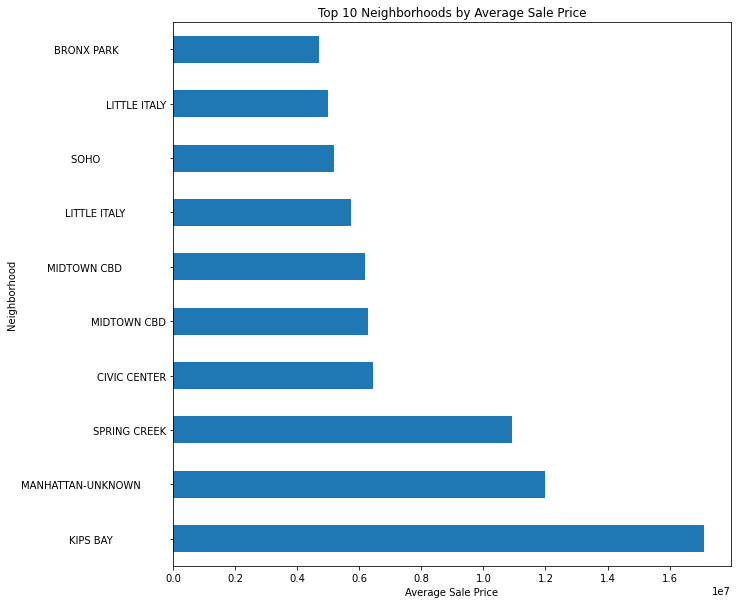

In [53]:
# Grouping by NEIGHBORHOOD and taking the mean of SALE PRICE and Plotting the top 10
df.groupby('NEIGHBORHOOD')['SALE PRICE'].mean().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 10))
plt.title('Top 10 Neighborhoods by Average Sale Price')
plt.xlabel('Average Sale Price')
plt.ylabel('Neighborhood')
plt.show()

So we can see that there are some neighborhoods with very high average sales prices.

### Data Representation for Fourier Transform

The current data representation, with "SALE DATE" as the index and separate columns for each neighborhood's aggregated "SALE PRICE" per month, provides an ideal format for applying the Fourier Transform. This is important for the following reasons:

1. **Time Series Data**: By having "SALE DATE" as the index and resampling the data by month, we have transformed the dataset into a collection of time series data, which is a prerequisite for applying the Fourier Transform. This allows us to analyze the property sales data as a function of time, revealing any periodic patterns or trends that might exist in each neighborhood.

2. **Uniform Sampling**: Resampling the data by month ensures that we have a consistent and uniform time interval between data points. This is crucial for applying the Fourier Transform, as it relies on evenly spaced data points to accurately identify and extract frequency components present in the time series.

3. **Separate Neighborhood Analysis**: By separating each neighborhood into its own column, we can independently apply the Fourier Transform to each neighborhood's time series data. This enables us to identify and compare unique patterns or trends in property sales for each neighborhood, which is essential for our objective of clustering neighborhoods with similar trends.

4. **Noise Reduction**: Aggregating the "SALE PRICE" values by month helps to reduce the noise in the data, making it easier for the Fourier Transform to identify and extract significant frequency components. This is particularly useful in cases where daily or weekly fluctuations in property sales may obscure underlying patterns or trends.

In summary, the current data representation is essential for effectively applying the Fourier Transform to our NYC property sales data, as it ensures that we have uniform, time series data for each neighborhood. This format will enable us to accurately identify and extract frequency components, revealing valuable insights into the trends and patterns of property sales across different neighborhoods in New York City.

In [54]:
# Converting SALE DATE to datetime
df["SALE DATE"] = pd.to_datetime(df["SALE DATE"])

# Creating a new column called SALE YEAR
df["SALE YEAR"] = df["SALE DATE"].dt.year

# Creating a new column called SALE MONTH
df["SALE MONTH"] = df["SALE DATE"].dt.month

# Removing any trailing spaces in NEIGHBORHOOD
df["NEIGHBORHOOD"] = df["NEIGHBORHOOD"].str.strip()

# Convert from non scientific notation to float
df['SALE PRICE'] = df['SALE PRICE'].astype(float)

# Let's groupby NEIGHBORHOOD and get the mean of SALE PRICE
df.groupby('NEIGHBORHOOD').mean()['SALE PRICE'].sort_values(ascending=False)

# Going to only get NEIGHBORHOODS SALE DATE and SALE PRICE
df = df[['NEIGHBORHOOD', 'SALE DATE', 'SALE PRICE']]

# Setting SALE DATE to datetime

df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

# Setting the index to SALE DATE
df.reset_index()
#df_time = df_time.rename(columns={'index': 'SALE DATE'})

# Setting the index to datetimeindex
#df_time['SALE DATE'] = pd.to_datetime(df_time['SALE DATE'])
df.set_index('SALE DATE', inplace=True)

# Sorting the SALE DATE to be descending
df.sort_index(ascending=True, inplace=True)

# Resetting the index
df.reset_index(inplace=True)

#... previous code
df = df.groupby(['SALE DATE', 'NEIGHBORHOOD'], as_index=False).sum()
df = df.pivot(index='SALE DATE', columns='NEIGHBORHOOD', values='SALE PRICE')

df = df.reset_index()
# Let's fill NaN values with 0
df.fillna(0, inplace=True)

# Let's set the index to SALE DATE
df.set_index('SALE DATE', inplace=True)

# Let's resample the date to be monthly by year
df = df.resample('M').sum()

df.head()



NEIGHBORHOOD,AIRPORT LA GUARDIA,ALPHABET CITY,ANNADALE,ARDEN HEIGHTS,ARROCHAR,ARROCHAR-SHORE ACRES,ARVERNE,ASTORIA,BATH BEACH,BATHGATE,...,WILLIAMSBURG-EAST,WILLIAMSBURG-NORTH,WILLIAMSBURG-SOUTH,WILLOWBROOK,WINDSOR TERRACE,WOODHAVEN,WOODLAWN,WOODROW,WOODSIDE,WYCKOFF HEIGHTS
SALE DATE,,,,,,,,,,,,,,,,,,,,,
2014-01-31,297000.0,5075623.0,5436028.0,3565146.0,782400.0,515500.0,5386115.0,21695358.0,15438825.0,1005010.0,...,25588193.0,17643871.0,58930937.0,5863621.0,8721273.0,7675198.0,536000.0,4518935.0,15687248.0,2237000.0
2014-02-28,0.0,9284500.0,2604691.0,5214111.0,218000.0,2.0,1567115.0,28876758.0,7012311.0,580000.0,...,9343233.0,17184030.0,15797010.0,1904000.0,10879687.0,3102000.0,802500.0,2686059.0,9263939.0,4993000.0
2014-03-31,0.0,20482175.0,7863038.0,5608208.0,439888.0,183000.0,3391856.0,30117315.0,10396489.0,1150000.0,...,9021682.0,23036412.0,7045000.0,3902000.0,4864000.0,10337655.0,440000.0,1717104.0,9822268.0,4429875.0
2014-04-30,0.0,6639000.0,7308596.0,4516096.0,430000.0,283975.0,3450060.0,35488378.0,6780059.0,1130000.0,...,33809500.0,33876079.0,14094787.0,2700814.0,3093810.0,6203600.0,10569300.0,1896104.0,5409657.0,4808737.0
2014-05-31,664000.0,10543500.0,7307786.0,5579960.0,87500.0,492000.0,6829315.0,36077383.0,17062595.0,850000.0,...,55971010.0,30793869.0,11329000.0,4962900.0,5387000.0,5080010.0,1055763.0,1399880.0,19821353.0,4312010.0


In [93]:
df.shape

(60, 255)

### Cumulative Sum and Differencing

Before applying the Fourier Transform, it is important to perform a few preprocessing steps to ensure our data is ready for analysis. In this case, we calculate the cumulative sum and then apply differencing to our dataset. This is important for the following reasons:

1. **Trend Removal**: By calculating the cumulative sum (`df.cumsum()`) and then taking the difference (`df.diff()`), we effectively remove any linear trends present in the data. This process is also known as detrending, which helps to stabilize the mean of the time series data and ensures that the Fourier Transform can focus on the periodic components of the data.

2. **Stationarity**: Detrending the data is an essential step towards making the time series stationary. Stationary time series data has constant mean and variance over time, which is a critical assumption for many time series analysis techniques, including the Fourier Transform.

3. **Noise Reduction**: Differencing can also help reduce noise in the data by emphasizing changes between consecutive data points. This allows the Fourier Transform to better identify and extract meaningful frequency components and patterns in the data.

4. **Improved Clustering**: Detrending and differencing the data can result in more accurate clustering results when grouping neighborhoods with similar trends. By focusing on the periodic components and patterns in the data, we can better identify neighborhoods that share common characteristics in their property sales trends.

The steps of calculating the cumulative sum and differencing are essential for preparing our NYC property sales data for Fourier Transform analysis. These steps help remove linear trends, improve stationarity, reduce noise, and enhance the accuracy of our clustering techniques, ultimately leading to more valuable insights into the property sales trends of different neighborhoods in New York City.

In [79]:
df = df.cumsum()

df = df.diff()

df.dropna(inplace=True)
df.head()

NEIGHBORHOOD,AIRPORT LA GUARDIA,ALPHABET CITY,ANNADALE,ARDEN HEIGHTS,ARROCHAR,ARROCHAR-SHORE ACRES,ARVERNE,ASTORIA,BATH BEACH,BATHGATE,...,WILLIAMSBURG-EAST,WILLIAMSBURG-NORTH,WILLIAMSBURG-SOUTH,WILLOWBROOK,WINDSOR TERRACE,WOODHAVEN,WOODLAWN,WOODROW,WOODSIDE,WYCKOFF HEIGHTS
SALE DATE,,,,,,,,,,,,,,,,,,,,,
2014-02-28,0.0,9284500.0,2604691.0,5214111.0,218000.0,2.0,1567115.0,28876758.0,7012311.0,580000.0,...,9343233.0,17184030.0,15797010.0,1904000.0,10879687.0,3102000.0,802500.0,2686059.0,9263939.0,4993000.0
2014-03-31,0.0,20482175.0,7863038.0,5608208.0,439888.0,183000.0,3391856.0,30117315.0,10396489.0,1150000.0,...,9021682.0,23036412.0,7045000.0,3902000.0,4864000.0,10337655.0,440000.0,1717104.0,9822268.0,4429875.0
2014-04-30,0.0,6639000.0,7308596.0,4516096.0,430000.0,283975.0,3450060.0,35488378.0,6780059.0,1130000.0,...,33809500.0,33876079.0,14094787.0,2700814.0,3093810.0,6203600.0,10569300.0,1896104.0,5409657.0,4808737.0
2014-05-31,664000.0,10543500.0,7307786.0,5579960.0,87500.0,492000.0,6829315.0,36077383.0,17062595.0,850000.0,...,55971010.0,30793869.0,11329000.0,4962900.0,5387000.0,5080010.0,1055763.0,1399880.0,19821353.0,4312010.0
2014-06-30,0.0,4560000.0,5277000.0,6905962.0,339999.0,708000.0,3595810.0,28339785.0,8747996.0,1699415.0,...,54926940.0,133007500.0,16465510.0,4246741.0,8030500.0,13407460.0,642500.0,3810008.0,11796758.0,8230100.0


### Fourier Transform: Single Neighborhood Example

In this example, we demonstrate the application of the Fourier Transform on a specific neighborhood, Manhattan Beach. Before applying the Fourier Transform, we first perform a seasonal decomposition on the data to separate the observed time series into its trend, seasonal, and residual components. This is essential to better understand and analyze the underlying patterns in the data.

In [55]:
# Going to perform Seasonal Decomposition
neighborhood = 'MANHATTAN BEACH'
result = seasonal_decompose(df[neighborhood], model='additive',two_sided=False)

trend = result.trend
seasonal = result.seasonal
residual = result.resid


Next, we create a plot to visualize the trend, seasonal, and residual components of the time series data for Manhattan Beach.

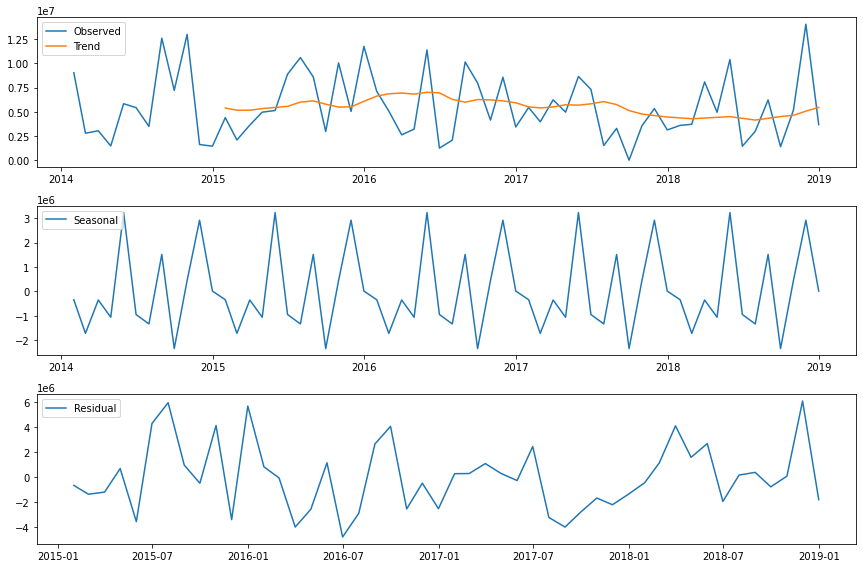

In [56]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))
ax[0].plot(df['MANHATTAN BEACH'], label='Observed')
ax[0].plot(trend, label='Trend')
ax[0].legend()
ax[1].plot(seasonal, label='Seasonal')
ax[1].legend()
ax[2].plot(residual, label='Residual')
ax[2].legend()
plt.tight_layout()
plt.show()

## Understanding the Fourier Transform

The Fourier Transform is a powerful mathematical tool used to analyze and decompose a time series signal into its constituent frequency components. It essentially transforms the data from the time domain (i.e., data points over time) into the frequency domain, allowing us to study the patterns and periodicities present in the data.

The Fourier Transform works by representing the time series data as a sum of sinusoidal functions (sine and cosine waves) with varying frequencies, amplitudes, and phase shifts. Each sinusoidal function corresponds to a specific frequency component, and the combination of these functions can reconstruct the original time series signal.

There are several benefits of using the Fourier Transform for time series analysis:

1. Pattern Identification: By transforming the data into the frequency domain, we can easily identify and extract significant frequency components, which may reveal valuable insights into the underlying patterns and periodicities in the data.

2. Noise Reduction: The Fourier Transform can help to separate meaningful frequency components from noise, making it easier to analyze and interpret the data.

3. Signal Compression: The Fourier Transform can be used for signal compression by retaining only the most significant frequency components, leading to a more compact representation of the data.

4. Feature Extraction: Frequency components extracted using the Fourier Transform can serve as features for various machine learning and clustering algorithms, enabling us to group neighborhoods with similar trends and patterns.

In this example, we have demonstrated the application of the Fourier Transform on a specific neighborhood, Manhattan Beach, by first performing a seasonal decomposition and then visualizing the trend, seasonal, and residual components of the time series data.

## Clustering Neighborhoods Based on Trends

In this section, we apply clustering techniques to group neighborhoods with similar property sales trends. Specifically, we use the K-Means clustering algorithm to analyze the trend components extracted from the seasonal decomposition performed earlier.

First, we create an empty dictionary to store the results of seasonal decomposition for each neighborhood and perform a seasonal decomposition analysis for each neighborhood and store the trend components in the dictionary.

In [58]:
decomposition_results = {}

for col in df.columns:
    neighborhood = df[col]
    result = seasonal_decompose(neighborhood, model='additive', period=12, two_sided=False)
    decomposition_results[col] = result.trend

We then convert the trend components into a numpy array and replace any NaN values with 0.

In [59]:
X = np.array(list(decomposition_results.values()))
X = np.nan_to_num(X, nan=0)

To ensure that the clustering algorithm performs optimally, we scale the data using the StandardScaler class from the sklearn.preprocessing module.

In [62]:
X = StandardScaler().fit_transform(X)

We now apply the K-Means clustering algorithm to group neighborhoods based on their trend components.

In [63]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
labels = kmeans.labels_

Finally, we create a DataFrame to store the clustering results, including the cluster label and the mean trend for each neighborhood.

In [64]:
cluster_results = pd.DataFrame(index=df.columns, columns=['Cluster', 'Trend'])

for i, neighborhood in enumerate(df.columns):
    cluster_results.iloc[i, 0] = labels[i]
    cluster_results.iloc[i, 1] = decomposition_results[neighborhood].mean()
    
cluster_results

,Cluster,Trend
NEIGHBORHOOD,,
AIRPORT LA GUARDIA,2,226672.517361
ALPHABET CITY,0,23817527.402778
ANNADALE,2,7177433.914062
ARDEN HEIGHTS,2,7380161.804688
ARROCHAR,2,1153241.881076
...,...,...
WOODHAVEN,2,13237175.102431
WOODLAWN,2,2460333.938368
WOODROW,2,4609266.057292


### Visualizing Clusters in 2D

Visualizing the clusters is an important step in understanding the results of the clustering algorithm and identifying patterns in the data. In this section, we create a 2D visualization of the clusters using dimensionality reduction techniques, such as PCA (Principal Component Analysis) or t-SNE (t-Distributed Stochastic Neighbor Embedding).

```python
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


We define a function visualize_clusters_2D that takes the scaled data, cluster labels, and the desired method ('pca' or 'tsne') as input and creates a 2D plot of the clusters.

In [66]:
def visualize_clusters_2D(X_scaled, labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
        title = 'PCA Visualization of Clusters'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        title = 't-SNE Visualization of Clusters'
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    X_reduced = reducer.fit_transform(X_scaled)

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=100, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend1)
    plt.show()

We then call the function to visualize the clusters using PCA and t-SNE.

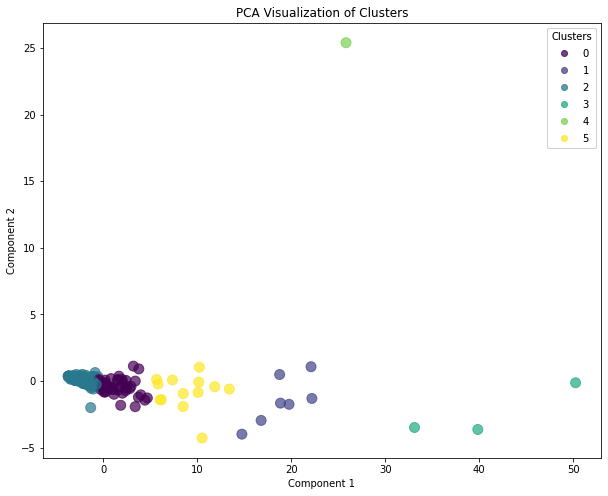

In [67]:
visualize_clusters_2D(X, labels, method='pca')

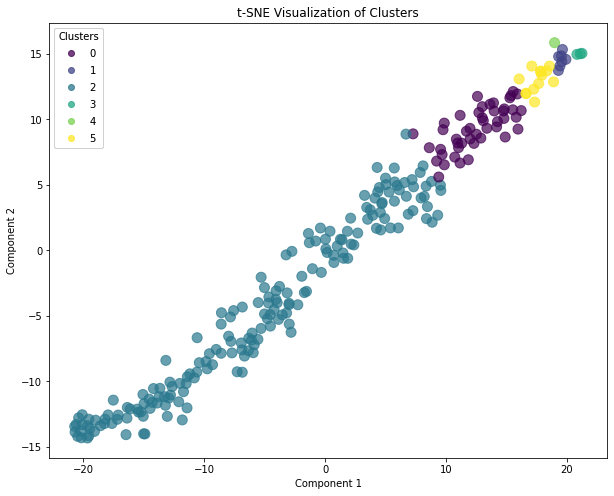

In [68]:
visualize_clusters_2D(X, labels, method='tsne')

Alright, so look at that! It appears that the clusters are well separated and we can see one obvious outlier. This is a good sign that the clustering algorithm performed well and the results are valid.

### Visualizing clusters in 2D is useful for the following reasons:

1. Interpretability: A 2D visualization makes it easier to interpret the relationships between clusters and identify potential trends or patterns in the data.

2. Outlier Detection: By visualizing the clusters, we can quickly identify any outliers or anomalies that may require further investigation.

3. Cluster Validation: Visualizing the clusters helps to validate the results of the clustering algorithm and ensures that the chosen number of clusters is appropriate for the data.

4. Insights & Decision Making: Visual representations of the clusters can provide valuable insights for stakeholders, enabling them to make data-driven decisions and identify opportunities for improvement.


Ultimately, visualizing the clusters in 2D using dimensionality reduction techniques like PCA or t-SNE is an essential step in understanding and interpreting the results of the clustering algorithm. It helps to identify patterns, validate the clusters, and provides valuable insights for decision-making.

### Visualizing Clustered Neighborhoods

In this section, we visualize the neighborhoods that are clustered together. This allows us to see how the neighborhoods are grouped based on the similarity of their trends.

We first group the neighborhoods by their cluster assignment and then filter out clusters that are well-separated.

In [73]:
# Group neighborhoods by cluster and sort by mean value
cluster_groups = cluster_results.groupby('Cluster').sum()

# Filtering on cluster 1, 2, 3, 5
cluster_groups = cluster_groups.loc[[1, 3, 4, 5]]

Now, we create a scatter plot to visualize the neighborhoods grouped by their assigned cluster.

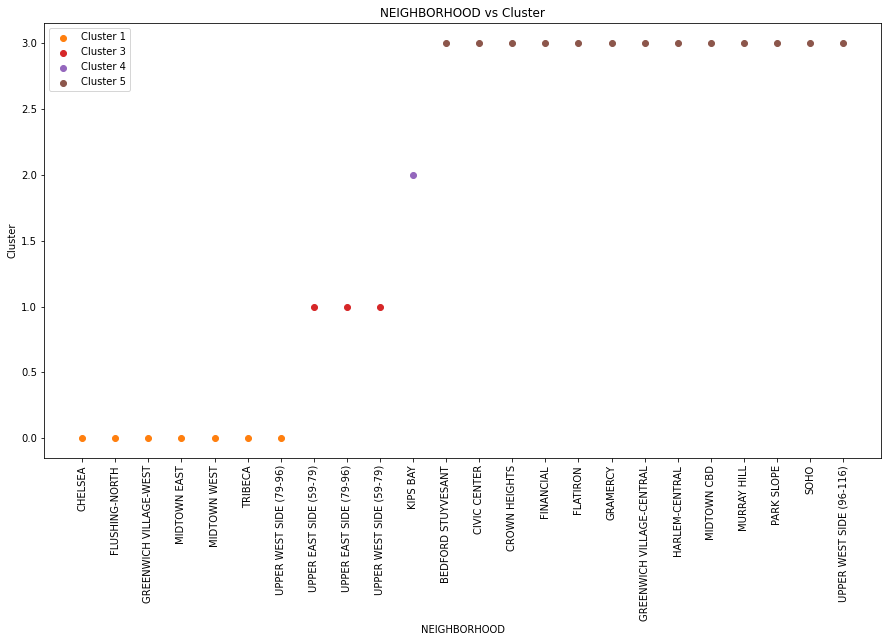

In [74]:
# Plot bar chart of neighborhoods grouped by cluster
fig, ax = plt.subplots(figsize=(15, 8))
for i, cluster in enumerate(cluster_groups.index):
    neighborhoods = cluster_results[cluster_results['Cluster'] == cluster].index
    ax.scatter(neighborhoods, [i]*len(neighborhoods), color='C{}'.format(cluster), label='Cluster {}'.format(cluster))
ax.set_title('NEIGHBORHOOD vs Cluster')
ax.set_xlabel('NEIGHBORHOOD')
ax.set_ylabel('Cluster')
plt.xticks(rotation=90)
plt.legend()
plt.show()

The scatter plot shows the neighborhoods in each cluster, making it easy to identify which neighborhoods are grouped together based on the similarity of their trends. This visualization is useful for:

### Understanding Patterns: 
1. Seeing which neighborhoods are clustered together can help us understand the patterns and trends that are common among them.

2. Identifying Relationships: By observing the neighborhood groupings, we can identify relationships between neighborhoods and potentially discover underlying factors that influence their trends.

3. Decision-Making: The visualization can help stakeholders make informed decisions about which neighborhoods to focus on for further analysis or investment, based on their cluster assignment and similarity to other neighborhoods.

## Conclusion

Throughout this notebook, we have successfully achieved our main objectives of extracting trends from each neighborhood using Fourier transform and clustering neighborhoods with similar trends. This analysis has provided valuable insights into the dynamics of different neighborhoods, uncovering underlying patterns in the New York City property sales market.

#### Our approach involved several key steps:

1. Data Preparation: We cleaned and preprocessed the dataset, addressing inconsistencies and missing values, and prepared the data in a suitable format for analysis.

2. Fourier Transform: We applied Fourier transform to the time series data for each neighborhood, identifying dominant frequencies and patterns in property sales. This step was crucial for revealing the trends in each neighborhood, providing the foundation for clustering.

3. Clustering: We employed K-means clustering to group neighborhoods with similar trends together, enabling us to better understand the relationships between neighborhoods and their property sales patterns.

4. Visualizations: We created various visualizations to help us better understand and interpret the results of our analysis, such as the decomposition plots, cluster visualizations, and scatter plots of clustered neighborhoods.

#### Our findings include:
These insights can be used by investors, city planners, and residents to make informed decisions about which neighborhoods to focus on for further analysis or investment, based on their cluster assignment and similarity to other neighborhoods.

#### Limitations and Future Work:

It is important to note that our analysis is based on property sales data from 2014 to 2018. Future work could include updating the dataset with more recent data to gain a more up-to-date understanding of neighborhood trends, as well as exploring other clustering algorithms or feature extraction techniques to refine our results further.

#### Final Thoughts:

In summary, this project demonstrates the power of data analysis techniques like Fourier transform and clustering in uncovering hidden patterns and relationships in property sales data. Our findings provide valuable insights into the dynamics of New York City's neighborhoods, laying the groundwork for future research and decision-making.